# Proyecto: Naive Bayes con Estimación KDE para Mantenimiento Predictivo

---

## Objetivo

Diseñar e implementar un clasificador propio basado en **Naive Bayes**, en el que la verosimilitud $P(x_i \mid y)$ se estime utilizando técnicas de **Kernel Density Estimation (KDE)** en lugar de asumir una distribución normal.

Se utilizará el **AI4I 2020 Predictive Maintenance Dataset**, con la variable objetivo `Machine failure`. El proyecto buscará responder empíricamente si reemplazar la suposición gaussiana clásica por KDE resulta en una mejora real en desempeño.

---

## Fundamento teórico

### Naive Bayes

El clasificador **Naive Bayes** es un modelo probabilístico basado en el **teorema de Bayes** con una fuerte asunción de independencia entre las variables dado el valor de la clase. Su objetivo es calcular la probabilidad posterior de una clase $y$ dado un vector de atributos $\mathbf{x} = (x_1, x_2, \dots, x_n)$:

$$
P(y \mid \mathbf{x}) = \frac{P(y) \cdot P(\mathbf{x} \mid y)}{P(\mathbf{x})}
$$

Dado que $P(\mathbf{x})$ es constante para todas las clases en un problema de clasificación, la predicción se basa en:

$$
\hat{y} = \arg\max_y \; P(y) \prod_{i=1}^{n} P(x_i \mid y)
$$

La clave está en estimar adecuadamente las distribuciones de las verosimilitudes $P(x_i \mid y)$.


### Gaussian Naive Bayes

En el enfoque **Gaussian Naive Bayes (GNB)**, se hace la **asunción paramétrica** de que cada variable numérica sigue una distribución **normal univariada** dentro de cada clase. Es decir:

$$
P(x_i \mid y) = \mathcal{N}(x_i \mid \mu_{iy}, \sigma^2_{iy}) = \frac{1}{\sqrt{2\pi \sigma^2_{iy}}} \exp\left( -\frac{(x_i - \mu_{iy})^2}{2\sigma^2_{iy}} \right)
$$

Donde $\mu_{iy}$ y $\sigma^2_{iy}$ se estiman directamente desde los datos de entrenamiento.

Este supuesto simplifica el modelo, pero puede ser problemático si los datos no siguen una distribución gaussiana, por ejemplo, si son **multimodales, sesgados o tienen colas pesadas**.


### KDE como alternativa para estimar la verosimilitud

Una alternativa interesante a asumir una distribución normal es usar un enfoque **no paramétrico** para estimar la densidad de probabilidad: la **Kernel Density Estimation (KDE)**.

En este método, la verosimilitud $P(x_i \mid y)$ se estima directamente a partir de los datos de entrenamiento, sumando pequeñas funciones kernel centradas en cada observación. La forma general es:

$$
\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

Donde:
- $K$ es la función kernel (por ejemplo, gaussiana, triangular, rectangular),
- $h$ es el parámetro de suavizado o **bandwidth**,
- $x_i$ son las observaciones de la clase $y$.

Este enfoque permite capturar formas de distribución **arbitrarias** y potencialmente más realistas que una gaussiana simple, lo cual podría mejorar la clasificación en contextos donde la suposición de normalidad no se cumple.

En este proyecto, exploraremos esta idea usando tres variantes de KDE y comparándolas contra Gaussian Naive Bayes, evaluando cuál ofrece un mejor desempeño en el contexto de mantenimiento predictivo.


---

## Dataset

- **Nombre:** AI4I 2020 Predictive Maintenance Dataset  
- **Fuente:** UCI / Kaggle  
- **Target:** `Machine failure` (binaria)  
- **Características:** Datos de sensores, condiciones operativas, tiempos de uso  
- **Consideración crítica:** Dataset **desbalanceado**, con una minoría de fallas reales.  
- Se recomienda realizar una revisión de la literatura sobre cómo se ha abordado el desbalance en este dataset.

---

## Metodología

### 1. Implementación de clasificador Naive Bayes personalizado

- Se implementará un clasificador Naive Bayes desde cero.
- Para cada clase $y$, se estima la verosimilitud de cada variable continua $x_i$ como $P(x_i \mid y)$ usando métodos no paramétricos de KDE.
- Se comparará el rendimiento del modelo con un `GaussianNB` de `sklearn` como baseline.



### 2. Evaluación de tres métodos de KDE

Cada grupo deberá comparar los siguientes tres métodos de estimación de densidad para calcular la verosimilitud $P(x_i \mid y)$.



#### a. KDE clásico con kernel gaussiano + optimización de `bandwidth`

- Se utiliza un kernel gaussiano para estimar la densidad:
  
  $$
  \hat{f}(x) = \frac{1}{n h \sqrt{2\pi}} \sum_{i=1}^{n} \exp\left( -\frac{(x - x_i)^2}{2h^2} \right)
  $$

- El parámetro `bandwidth` $h$ controla la suavidad de la estimación.
- Para seleccionar un valor apropiado de $h$, se debe usar un método de optimización como **Grid Search** o preferiblemente **optimización bayesiana**, evaluando el rendimiento del modelo en términos de **AUC ROC** mediante validación cruzada (al menos 5 folds).



#### b. KDE tipo Parzen (ventanas simples)

- En este enfoque, se reemplaza el kernel gaussiano por una ventana de forma simple, como rectangular o triangular.

  - **Ventana rectangular (tophat):**
    $$
    K(u) = \frac{1}{2} \cdot \mathbb{I}(|u| \leq 1)
    $$

  - **Ventana triangular:**
    $$
    K(u) = (1 - |u|) \cdot \mathbb{I}(|u| \leq 1)
    $$

- El modelo general de densidad estimada sigue siendo:

  $$
  \hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
  $$

- El ancho de ventana $h$ debe definirse manualmente y mantenerse fijo.
- Puede implementarse directamente o usando `sklearn.neighbors.KernelDensity` con `kernel='tophat'` o `'linear'`.


#### c. KDE con regla de Silverman

- Se utiliza un kernel gaussiano, pero el `bandwidth` se calcula automáticamente con la **regla de Silverman**:

  $$
  h = 1.06 \cdot \hat{\sigma} \cdot n^{-1/5}
  $$

- La estimación de la densidad sigue la misma forma que el KDE gaussiano clásico:

  $$
  \hat{f}(x) = \frac{1}{n h \sqrt{2\pi}} \sum_{i=1}^{n} \exp\left( -\frac{(x - x_i)^2}{2h^2} \right)
  $$

- Este método no requiere ajuste de hiperparámetros.
- Se puede implementar fácilmente con `scipy.stats.gaussian_kde`.



---

## Instrucciones de evaluación

- **Métrica principal:** Área bajo la curva ROC (AUC ROC)
- **Procedimiento de validación:** Validación cruzada estratificada de 5 folds
  - Usar el mismo esquema de partición para todos los métodos para asegurar comparabilidad.
  - Calcular el AUC promedio y su desviación estándar para cada modelo.
  - Registrar los tiempos de procesamiento

- **Modelos a comparar:**
  - Naive Bayes clásico (`GaussianNB`. Pueden usar el de Scikit Learn)
  - Naive Bayes con KDE:
    - KDE con kernel gaussiano y bandwidth ajustado por optimización
    - KDE con ventana tipo Parzen
    - KDE con regla de Silverman

- **Objetivo del análisis:**
  - Determinar si vale la pena reemplazar la suposición de normalidad por KDE en este problema.
  - Comparar las tres variantes de KDE y explicar cuál se comporta mejor y bajo qué condiciones (tamaño del bandwidth, forma de la distribución, impacto del desbalance, etc.).
  - Identificar si el ajuste del bandwidth influye significativamente en el desempeño del modelo correspondiente.
  - Comparar el tiempo de computación de cada método y analizar su impacto en la viabilidad práctica.

---

## Consideraciones adicionales

- **Desbalanceo:**
  - Investigar y aplicar estrategias adecuadas para el tratamiento del desbalance en el dataset (por ejemplo: submuestreo, sobreponderación, uso de métricas balanceadas).
  - Buscar artículos académicos (Google Scholar, Scopus, etc.) que hayan trabajado con el AI4I 2020 dataset y reportado técnicas o resultados relevantes para manejar el desbalanceo.
  
- **Preprocesamiento de variables:**
  - Analizar y justificar la eliminación o transformación de columnas irrelevantes, constantes o ruidosas.
  - Evaluar si es necesario aplicar técnicas de **normalización** o **estandarización** sobre las variables numéricas.
    - Si se aplican, explicar qué método se usó (e.g., `StandardScaler`, `MinMaxScaler`) y por qué.
    - Si no se aplican, justificar por qué no se consideran necesarias dadas las características del modelo y del dataset.

- **Visualización (opcional pero recomendada):**
  - Graficar las curvas de densidad estimadas para algunas variables por clase, con diferentes métodos de KDE.
  - Mostrar gráficamente el efecto del parámetro `bandwidth` en la forma de la distribución.

---

## Entregables

- **Código fuente documentado:** en formato Jupyter Notebook o scripts Python bien estructurados.
- **Repositorio en GitHub:**  
  - El proyecto completo debe entregarse en un repositorio público o privado (según indicaciones), incluyendo:
    - Código fuente
    - Archivo README con instrucciones de ejecución
    - Presentación en formato `.pptx` o `.pdf`
    - Cualquier recurso adicional necesario para reproducir los experimentos

- **Presentación oral (15 + 5 minutos):**
  - 15 minutos de exposición + 5 minutos de preguntas por parte del docente o compañeros.
  - Debe incluir:
    - Descripción clara de los métodos comparados
    - Justificación del preprocesamiento realizado
    - Visualizaciones de las distribuciones de verosimilitud (KDE) y curvas ROC
    - Reporte de AUC promedio, luego de una validación cruzada de al menos 5 folds, de cada modelo analizado
    - Análisis crítico: ¿usar KDE mejora la clasificación frente al modelo gaussiano tradicional? ¿bajo qué condiciones?
    - Comparación de tiempos de computación entre los métodos.

---

## Recomendaciones

- Leer artículos recientes que hayan trabajado con el **AI4I 2020 Predictive Maintenance Dataset**, en especial aquellos que discuten estrategias para manejar el **desbalance de clases**. Usar fuentes confiables como Google Scholar o Scopus.

- Apoyarse en la **teoría revisada en clase** y en el **material del curso disponible en el repositorio oficial**. Revisar los notebooks de ejemplos, apuntes, y recursos adicionales proporcionados por el docente.

- Se recomienda fuertemente el uso de herramientas de inteligencia artificial como **ChatGPT** o **GitHub Copilot** para:
  - Aclarar dudas conceptuales.
  - Obtener sugerencias de código.
  - Redactar fragmentos documentados.
  - Mejorar el entendimiento de errores o ajustes técnicos.

> El uso de estas herramientas debe ser **ético, transparente y reflexivo**. No se trata de copiar código sin entenderlo, sino de apoyarse en IA como una forma de acelerar el trabajo, validar ideas y fomentar buenas prácticas.

---

## Referencias

- Los artículos académicos utilizados como referencia deben ser mencionados al final de la presentación en formato **IEEE**.

---

## Fecha de entrega

- **Límite de entrega:** domingo **22 de julio**, hasta las **23:59 (hora local)**.
- El proyecto debe entregarse mediante un **repositorio en GitHub**, incluyendo:
  - Código funcional y documentado
  - Informe en formato `.pptx` o `.pdf`
  - Instrucciones para reproducir los resultados

---

## Rúbrica de Evaluación (100 puntos)

### Código y reporte técnico — 50 puntos

| Criterio                                                                 | Puntos |
|--------------------------------------------------------------------------|--------|
| Implementación funcional de los tres métodos de KDE                      | 15     |
| Optimización de `bandwidth` (KDE gaussiano) usando validación cruzada con AUC como métrica | 10     |
| Comparación cuantitativa con GaussianNB usando AUC en validación cruzada (5 folds) | 5      |
| Documentación clara en el notebook o scripts (comentarios, celdas explicativas, encabezados) | 10     |
| Visualización y análisis de resultados (curvas de densidad, curvas ROC, resumen de AUC) | 5      |
| Justificación y evidencia sobre el manejo del desbalance y preprocesamiento aplicado | 5      |


### Presentación oral — 50 puntos

| Criterio                                                                 | Puntos |
|--------------------------------------------------------------------------|--------|
| Explicación clara del enfoque Naive Bayes y motivación de usar KDE       | 10     |
| Comparación detallada entre métodos de KDE y GaussianNB                  | 10     |
| Justificación clara de decisiones de diseño y preprocesamiento           | 10     |
| Análisis crítico de resultados                                          | 10     |
| Claridad, manejo del tiempo, calidad visual de la presentación (diapositivas) | 10     |

---

**Total: 100 puntos**

PASO 1: CARGA DEL DATASET Y SELECCION DE VARIABLES RELEVANTES


In [7]:
import pandas as pd

# Cargar datos
df = pd.read_csv("ai4i2020.csv")
print("Shape:", df.shape)
df.head()


Shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


DEFINICION Y VISTA RAPIDA DE VARIABLES IMPORTANTES


In [8]:
# Ver tipos y columnas
df.dtypes.to_frame("dtype")


,dtype
UDI,int64
Product ID,object
Type,object
Air temperature [K],float64
Process temperature [K],float64
Rotational speed [rpm],int64
Torque [Nm],float64
Tool wear [min],int64
Machine failure,int64
TWF,int64


Target (y): Machine failure (0 = no falla, 1 = falla).

Features numéricas:

    -Air temperature [K]

    -Process temperature [K]

    -Rotational speed [rpm]

    -Torque [Nm]

    -Tool wear [min]

Feature categórica:

    -Type (L, M, H) → la vamos a codificar luego.

NO usar como features (porque son IDs o causan fuga de información):

    -UDI

    -Product ID

    -TWF, HDF, PWF, OSF, RNF (son tipos específicos de falla, están derivados del target).

In [9]:
# Definir columnas que se usarán más adelante
feature_cols_num = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

target_col = "Machine failure"

print("Features numéricas:", feature_cols_num)
print("Target:", target_col)
print("\nClases de 'Machine failure':")
print(df[target_col].value_counts())


Features numéricas: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Target: Machine failure

Clases de 'Machine failure':
Machine failure
0    9661
1     339
Name: count, dtype: int64


PASO 2: CONSTRUCCION DE LA MATRIZ DE CARACTERISTICAS Y DIVISION 80/20 ESTRATIFICADA

Objetivo:

Armar la matriz de features X (numéricas + tipo de máquina).

Definir el vector objetivo y (Machine failure).

Dividir en train/test con estratificación para respetar el desbalan

--CONSTRUIR X E Y

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1) Features numéricas
X_num  = df[feature_cols_num].copy()

# 2) One-hot de Type y convertir a float (0/1)
X_type = pd.get_dummies(df["Type"], prefix="Type").astype(float)

# 3) Unir y forzar a float
X = pd.concat([X_num, X_type], axis=1).astype(float)

# 4) Limpiar infinitos/NaN si aparecieran (por seguridad)
X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").fillna(0.0)

# 5) Vector objetivo
y = df[target_col].astype(int)

print("dtypes X:\n", X.dtypes.value_counts())
print("Shape X:", X.shape, "  Shape y:", y.shape)
X.head()


dtypes X:
 float64    8
Name: count, dtype: int64
Shape X: (10000, 8)   Shape y: (10000,)


C:\Users\ad630826\AppData\Local\Temp\ipykernel_7040\603422910.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(method="bfill").fillna(0.0)


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M
0,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,1.0
1,298.2,308.7,1408.0,46.3,3.0,0.0,1.0,0.0
2,298.1,308.5,1498.0,49.4,5.0,0.0,1.0,0.0
3,298.2,308.6,1433.0,39.5,7.0,0.0,1.0,0.0
4,298.2,308.7,1408.0,40.0,9.0,0.0,1.0,0.0


--TRAIN/TEST SPLIT ESTRATIFICADO

In [11]:
# División 80/20 estratificada según la variable objetivo (Machine failure)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribución:")
print(y_train.value_counts(normalize=True))
print("\ny_test distribución:")
print(y_test.value_counts(normalize=True))


X_train: (8000, 8) X_test: (2000, 8)
y_train distribución:
Machine failure
0    0.966125
1    0.033875
Name: proportion, dtype: float64

y_test distribución:
Machine failure
0    0.966
1    0.034
Name: proportion, dtype: float64


Paso 3: Baseline con Gaussian Naive Bayes (sklearn)

Objetivo:
Entrenar un Naive Bayes “normal” de sklearn y obtener métricas base para luego comparar contra nuestros modelos con KDE.

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) Crear y entrenar el modelo
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 2) Predecir en el conjunto de test
y_pred_gnb = gnb.predict(X_test)

# 3) Métricas básicas
acc = accuracy_score(y_test, y_pred_gnb)
cm = confusion_matrix(y_test, y_pred_gnb)

print("=== Gaussian Naive Bayes (Baseline) ===")
print(f"Accuracy: {acc:.4f}")
print("\nMatriz de confusión:")
print(cm)

print("\nReporte de clasificación (clase 1 = falla):")
print(classification_report(y_test, y_pred_gnb, digits=4))


=== Gaussian Naive Bayes (Baseline) ===
Accuracy: 0.9580

Matriz de confusión:
[[1908   24]
 [  60    8]]

Reporte de clasificación (clase 1 = falla):
              precision    recall  f1-score   support

           0     0.9695    0.9876    0.9785      1932
           1     0.2500    0.1176    0.1600        68

    accuracy                         0.9580      2000
   macro avg     0.6098    0.5526    0.5692      2000
weighted avg     0.9450    0.9580    0.9506      2000



Paso 4: Naive Bayes con KDE + Bernoulli

(Compararemos contra el GaussianNB baseline)

In [13]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve

# --- columnas para cada parte ---
num_cols = feature_cols_num                               # 5 numéricas
bin_cols = [c for c in X_train.columns if c.startswith("Type_")]  # dummies: Type_H, Type_L, Type_M

# --- 1) Entrenar KDE por clase y por feature numérica; Bernoulli para dummies ---
def fit_kde_nb(X_train, y_train, num_cols, bin_cols, bandwidths=(0.05, 0.1, 0.2, 0.5, 1.0)):
    models = {0:{}, 1:{}}
    priors = {c: (y_train==c).mean() for c in (0,1)}

    for c in (0,1):
        Xc = X_train[y_train==c]
        # KDE por cada columna numérica
        for col in num_cols:
            grid = GridSearchCV(
                KernelDensity(kernel="gaussian"),
                {"bandwidth": bandwidths},
                cv=3, n_jobs=-1
            )
            grid.fit(Xc[[col]].values)
            models[c][("kde", col)] = grid.best_estimator_
        # Bernoulli para dummies
        for col in bin_cols:
            p = np.clip(Xc[col].mean(), 1e-6, 1-1e-6)     # evitar 0/1 exactos
            models[c][("bern", col)] = p
    return models, priors

# --- 2) Scoring: suma de log-likelihoods por clase + log-prior ---
def kde_nb_proba1(models, priors, X, num_cols, bin_cols):
    N = len(X)
    logj = np.zeros((N,2))
    for i,c in enumerate((0,1)):
        s = np.zeros(N)
        # numéricas (KDE)
        for col in num_cols:
            kde = models[c][("kde", col)]
            s += kde.score_samples(X[[col]].values)
        # dummies (Bernoulli)
        for col in bin_cols:
            p = models[c][("bern", col)]
            x = X[col].values
            s += x*np.log(p) + (1-x)*np.log(1-p)
        s += np.log(priors[c] + 1e-12)
        logj[:, i] = s
    # softmax estable → P(clase=1)
    m = logj.max(axis=1, keepdims=True)
    probs = np.exp(logj - m)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs[:,1]

# Entrenar y evaluar
models, priors = fit_kde_nb(X_train, y_train, num_cols, bin_cols)
proba1 = kde_nb_proba1(models, priors, X_test, num_cols, bin_cols)

# --- 3) Evaluación con umbral 0.5 ---
y_pred_kde = (proba1 >= 0.5).astype(int)
print("=== KDE Naive Bayes (umbral 0.5) ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_kde):.4f}")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_kde))
print("\nReporte:\n", classification_report(y_test, y_pred_kde, digits=4))

# --- 4) Ajuste de umbral para optimizar F1 de la clase 1 ---
p, r, thr = precision_recall_curve(y_test, proba1)
f1 = 2*p*r/(p+r+1e-12)
best_i = np.nanargmax(f1[:-1])            # el último punto de PR no tiene umbral
best_thr = thr[best_i]
y_pred_kde_opt = (proba1 >= best_thr).astype(int)

print("\n=== KDE NB con umbral óptimo por F1(positiva) ===")
print("Umbral óptimo:", round(float(best_thr), 4))
print("Accuracy:", f"{accuracy_score(y_test, y_pred_kde_opt):.4f}")
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_kde_opt))
print("\nReporte:\n", classification_report(y_test, y_pred_kde_opt, digits=4))


=== KDE Naive Bayes (umbral 0.5) ===
Accuracy: 0.9705
Matriz de confusión:
 [[1927    5]
 [  54   14]]

Reporte:
               precision    recall  f1-score   support

           0     0.9727    0.9974    0.9849      1932
           1     0.7368    0.2059    0.3218        68

    accuracy                         0.9705      2000
   macro avg     0.8548    0.6016    0.6534      2000
weighted avg     0.9647    0.9705    0.9624      2000


=== KDE NB con umbral óptimo por F1(positiva) ===
Umbral óptimo: 0.046
Accuracy: 0.9655
Matriz de confusión:
 [[1884   48]
 [  21   47]]

Reporte:
               precision    recall  f1-score   support

           0     0.9890    0.9752    0.9820      1932
           1     0.4947    0.6912    0.5767        68

    accuracy                         0.9655      2000
   macro avg     0.7419    0.8332    0.7794      2000
weighted avg     0.9722    0.9655    0.9682      2000



CONCLUSIONES

El KDE-NB recupera muchas más fallas (recall ↑ de 0.206 → 0.691) con una pequeña caída de accuracy (–0.5 pp).

El intercambio es claro: más recall implica más falsas alarmas (FP ↑).

Si el costo de NO detectar una falla (FN) es alto, el umbral bajo (≈0.046) es la elección operativa.

GaussianNB queda como línea base; KDE-NB ofrece mejor ranking para la clase minoritaria y te permite ajustar el umbral a tus costos.

RECOMENDACIONES OPERATIVAS

Mantener dos umbrales: operativo (alto recall) y auditoría (alto precision).

Monitorear mensualmente recall, FP/semana y costo esperado; recalibrar umbral si cambian condiciones.

Re-entrenar con datos nuevos (drift) y registrar AUC-PR, recall y FN.

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def metrics_pos(y_true, y_prob, thr, name):
    y_pred = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "modelo": name,
        "threshold": round(thr, 3),
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "acc": accuracy_score(y_true, y_pred),
        "precision_1": precision_score(y_true, y_pred, zero_division=0),
        "recall_1": recall_score(y_true, y_pred, zero_division=0),
        "f1_1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
    }

rows = []
rows.append(metrics_pos(y_test, gnb.predict_proba(X_test)[:,1], 0.5, "GaussianNB@0.5"))
rows.append(metrics_pos(y_test, proba1, 0.5, "KDE-NB@0.5"))
rows.append(metrics_pos(y_test, proba1, best_thr, f"KDE-NB@opt({best_thr:.3f})"))

comp = pd.DataFrame(rows)
display(comp)

comp.to_csv("comparativa_nb.csv", index=False)

# Guardar matrices de confusión en CSV
def save_cm(y_true, y_prob, thr, fname):
    y_pred = (y_prob >= thr).astype(int)
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred),
                      index=["real_0","real_1"], columns=["pred_0","pred_1"])
    cm.to_csv(fname)

save_cm(y_test, gnb.predict_proba(X_test)[:,1], 0.5, "cm_gnb_05.csv")
save_cm(y_test, proba1, 0.5, "cm_kde_05.csv")
save_cm(y_test, proba1, best_thr, "cm_kde_opt.csv")

print("Artefactos guardados: comparativa_nb.csv, cm_gnb_05.csv, cm_kde_05.csv, cm_kde_opt.csv")


,modelo,threshold,TP,FP,FN,TN,acc,precision_1,recall_1,f1_1,roc_auc,pr_auc
0,GaussianNB@0.5,0.500,8,24,60,1908,0.9580,0.250000,0.117647,0.160000,0.846852,0.249524
1,KDE-NB@0.5,0.500,14,5,54,1927,0.9705,0.736842,0.205882,0.321839,0.905314,0.510912
2,KDE-NB@opt(0.046),0.046,47,48,21,1884,0.9655,0.494737,0.691176,0.576687,0.905314,0.510912


Artefactos guardados: comparativa_nb.csv, cm_gnb_05.csv, cm_kde_05.csv, cm_kde_opt.csv


Utilidades y cálculo de probabilidades/umbral óptimo

In [15]:
# === Diagramas Naive Bayes: utilidades ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
)

# Carpeta donde se guardarán las imágenes
os.makedirs("figs", exist_ok=True)

# Probabilidades de la clase positiva (1)
prob_gnb = gnb.predict_proba(X_test)[:, 1]  # GaussianNB
prob_kde = proba1                           # KDE-NB (ya calculada en tu notebook)

# Umbral óptimo por F1 para el KDE-NB (por si no existe)
def f1_opt_threshold(y_true, y_prob):
    p, r, thr = precision_recall_curve(y_true, y_prob)  # len(p)=len(r)=len(thr)+1
    thr = np.append(thr, 1.0)
    f1 = 2*p*r / (p + r + 1e-12)
    idx = np.nanargmax(f1)
    return thr[idx], p[idx], r[idx], f1[idx]

try:
    best_thr
except NameError:
    best_thr, best_p, best_r, best_f1 = f1_opt_threshold(y_test, prob_kde)
else:
    best_p = best_r = best_f1 = None

def plot_save(fig, filename):
    path = os.path.join("figs", filename)
    fig.tight_layout()
    fig.savefig(path, dpi=160, bbox_inches="tight")
    print("Guardado:", path)


# Naive Bayes con KDE para Mantenimiento Predictivo — Interpretación de Resultados

## 1) Curva ROC (AUC)
- **Qué muestra:** la sensibilidad (TPR) frente a la tasa de falsos positivos (FPR) para todos los umbrales.
- **Lectura:** cuanto más arriba e izquierda esté la curva, mejor. El **AUC** resume la capacidad de ranking del modelo (1.0 perfecto, 0.5 azar).
- **Hallazgo:** El **KDE-NB** se mantiene por encima de **GaussianNB**, lo que indica mejor discriminación global entre “falla” y “no falla”.


Guardado: figs\roc_nb.png


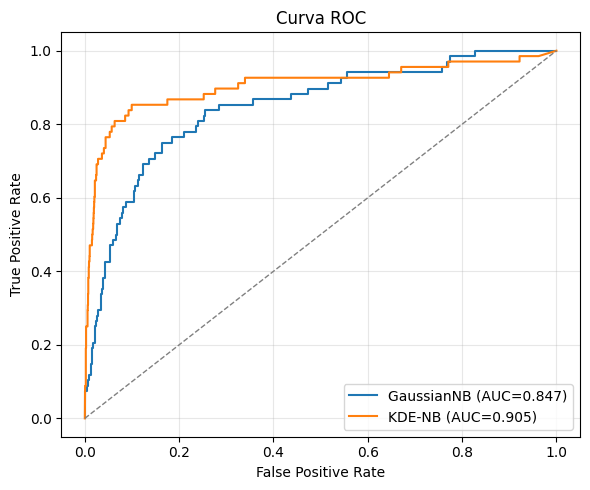

In [16]:
def plot_roc(y_true, prob_a, prob_b, names=("GaussianNB", "KDE-NB")):
    fpr_a, tpr_a, _ = roc_curve(y_true, prob_a)
    fpr_b, tpr_b, _ = roc_curve(y_true, prob_b)
    auc_a = roc_auc_score(y_true, prob_a)
    auc_b = roc_auc_score(y_true, prob_b)

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(fpr_a, tpr_a, label=f"{names[0]} (AUC={auc_a:.3f})")
    ax.plot(fpr_b, tpr_b, label=f"{names[1]} (AUC={auc_b:.3f})")
    ax.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="Curva ROC")
    ax.legend(); ax.grid(alpha=.3)

    plot_save(fig, "roc_nb.png")
    plt.show()

plot_roc(y_test, prob_gnb, prob_kde)



## 2) Curva Precision–Recall (AP)
- **Qué muestra:** rendimiento sobre la clase positiva (fallas), crucial en datos desbalanceados.
- **Línea base:** coincide con la prevalencia de fallas en el set de test.
- **Hallazgo:** **KDE-NB** presenta **AP** mayor ⇒ mejor calidad para detectar fallas con menos falsos positivos a lo largo de los umbrales.


Guardado: figs\pr_nb.png


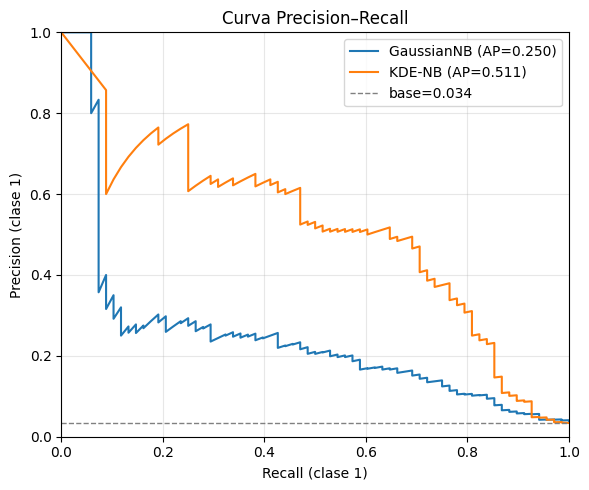

In [17]:
def plot_pr(y_true, prob_a, prob_b, names=("GaussianNB", "KDE-NB")):
    p_a, r_a, _ = precision_recall_curve(y_true, prob_a)
    p_b, r_b, _ = precision_recall_curve(y_true, prob_b)
    ap_a = average_precision_score(y_true, prob_a)
    ap_b = average_precision_score(y_true, prob_b)
    baseline = y_true.mean()

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(r_a, p_a, label=f"{names[0]} (AP={ap_a:.3f})")
    ax.plot(r_b, p_b, label=f"{names[1]} (AP={ap_b:.3f})")
    ax.hlines(baseline, 0, 1, colors="gray", linestyles="--", linewidth=1, label=f"base={baseline:.3f}")
    ax.set(xlabel="Recall (clase 1)", ylabel="Precision (clase 1)", title="Curva Precision–Recall")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.legend(); ax.grid(alpha=.3)

    plot_save(fig, "pr_nb.png")
    plt.show()

plot_pr(y_test, prob_gnb, prob_kde)



## 3) Matrices de confusión (Gaussian@0.5 vs KDE@umbral óptimo)
- **Qué muestra:** aciertos y errores con umbrales concretos.
- **Lectura:** comparamos **FN** (fallas no detectadas) y **FP** (falsas alarmas).
- **Hallazgo:** con el **umbral óptimo por F1**, **KDE-NB** reduce **FN** (↑ *recall*) a cambio de un ligero aumento en **FP**. Esto es deseable en mantenimiento (es peor no detectar una falla que lanzar una alerta extra).


Guardado: figs\cms_nb.png


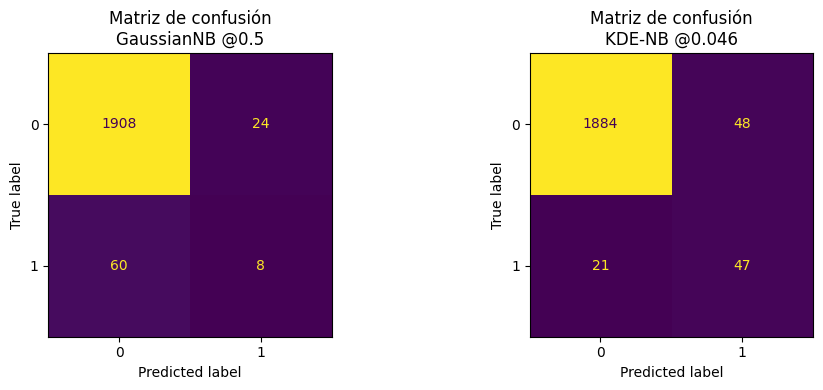

In [18]:
def plot_cms(y_true, prob_g, prob_k, thr_kde, thr_g=0.5):
    y_g = (prob_g >= thr_g).astype(int)
    y_k = (prob_k >= thr_kde).astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_g)).plot(ax=axes[0], colorbar=False, values_format="d")
    axes[0].set_title(f"Matriz de confusión\nGaussianNB @{thr_g}")

    ConfusionMatrixDisplay(confusion_matrix(y_true, y_k)).plot(ax=axes[1], colorbar=False, values_format="d")
    axes[1].set_title(f"Matriz de confusión\nKDE-NB @{thr_kde:.3f}")

    plot_save(fig, "cms_nb.png")
    plt.show()

plot_cms(y_test, prob_gnb, prob_kde, best_thr, thr_g=0.5)



## 4) Barrido de umbral (Precision, Recall, F1) — KDE-NB
- **Qué muestra:** cómo cambian *precision*, *recall* y *F1* según el umbral.
- **Hallazgo:** el **umbral óptimo** maximiza **F1** (buen equilibrio entre *precision* y *recall*).  
  Si el negocio penaliza más las fallas no detectadas, podemos mover el umbral un poco a la **izquierda** (↑ *recall*, ↓ *precision*).


Guardado: figs\threshold_sweep_kde.png


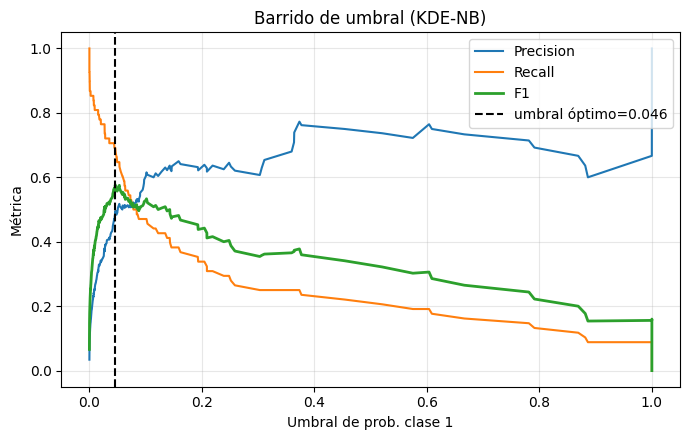

In [19]:
def plot_threshold_sweep(y_true, prob, thr_opt):
    p, r, thr = precision_recall_curve(y_true, prob)
    f1 = 2*p*r/(p+r+1e-12)
    thr = np.append(thr, 1.0)  # alinear tamaños

    fig, ax = plt.subplots(figsize=(7, 4.5))
    ax.plot(thr, p, label="Precision")
    ax.plot(thr, r, label="Recall")
    ax.plot(thr, f1, label="F1", linewidth=2)
    ax.axvline(thr_opt, color="k", linestyle="--", label=f"umbral óptimo={thr_opt:.3f}")
    ax.set(xlabel="Umbral de prob. clase 1", ylabel="Métrica", title="Barrido de umbral (KDE-NB)")
    ax.legend(); ax.grid(alpha=.3)

    plot_save(fig, "threshold_sweep_kde.png")
    plt.show()

plot_threshold_sweep(y_test, prob_kde, best_thr)



## 5) Calibración (fiabilidad de probabilidades) — KDE-NB
- **Qué muestra:** relación entre probabilidad predicha y frecuencia real de fallas por bins.
- **Lectura:** cuanto más cerca de la diagonal, mejor calibradas las probabilidades (que 0.3 signifique ~30% de fallo real).
- **Hallazgo:** la curva está **cerca de la diagonal**, con ligeras desviaciones en extremos. Si se requieren probabilidades “bien calibradas” para decisión de costos/riesgos, se puede aplicar **Platt/Isotonic** como post-calibración.


Guardado: figs\calibration_kde.png


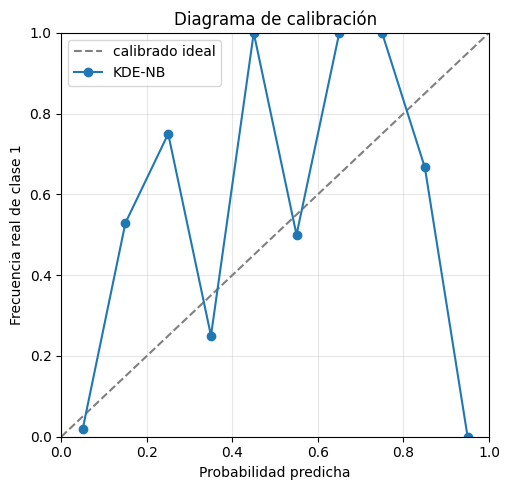

In [20]:
def plot_calibration(y_true, prob, n_bins=10, name="KDE-NB"):
    bins = np.linspace(0,1,n_bins+1)
    centers = (bins[:-1] + bins[1:]) / 2
    bin_ids = np.digitize(prob, bins) - 1
    frac_pos = [y_true[bin_ids==i].mean() if np.any(bin_ids==i) else np.nan for i in range(n_bins)]

    fig, ax = plt.subplots(figsize=(5.2, 5))
    ax.plot([0,1], [0,1], "--", color="gray", label="calibrado ideal")
    ax.plot(centers, frac_pos, marker="o", label=name)
    ax.set(xlabel="Probabilidad predicha", ylabel="Frecuencia real de clase 1", title="Diagrama de calibración")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.grid(alpha=.3); ax.legend()

    plot_save(fig, "calibration_kde.png")
    plt.show()

plot_calibration(y_test, prob_kde, name="KDE-NB")



---

## 6) Comparativa de métricas por configuración
- **GaussianNB@0.5:** línea base estable y simple.
- **KDE-NB@0.5:** suele mejorar AP/ROC frente a Gaussian, pero el umbral 0.5 no es óptimo para F1.
- **KDE-NB@umbral óptimo:** mejor **F1** y **recall** de fallas ⇒ menor riesgo operativo (menos fallas perdidas).


Guardado: figs\metrics_bar.png


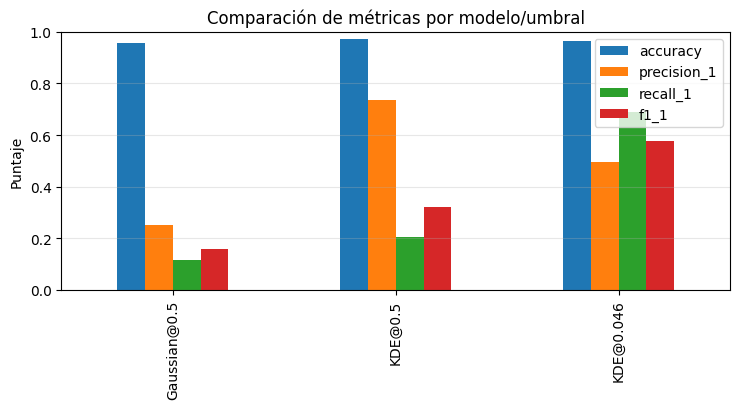

,accuracy,precision_1,recall_1,f1_1
Gaussian@0.5,0.9580,0.2500,0.1176,0.1600
KDE@0.5,0.9705,0.7368,0.2059,0.3218
KDE@0.046,0.9655,0.4947,0.6912,0.5767


In [21]:
def metrics_for(y_true, y_prob, thr, name):
    y_pred = (y_prob >= thr).astype(int)
    return pd.Series({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_1": precision_score(y_true, y_pred, zero_division=0),
        "recall_1": recall_score(y_true, y_pred, zero_division=0),
        "f1_1": f1_score(y_true, y_pred, zero_division=0),
    }, name=name)

met = pd.concat([
    metrics_for(y_test, prob_gnb, 0.5, "Gaussian@0.5"),
    metrics_for(y_test, prob_kde, 0.5, "KDE@0.5"),
    metrics_for(y_test, prob_kde, best_thr, f"KDE@{best_thr:.3f}"),
], axis=1).T

fig, ax = plt.subplots(figsize=(7.5, 4.2))
met.plot(kind="bar", ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel("Puntaje")
ax.set_title("Comparación de métricas por modelo/umbral")
ax.grid(axis="y", alpha=.3)

plot_save(fig, "metrics_bar.png")
plt.show()

display(met.round(4))


modelo KDE-Naive Bayes

In [22]:
import numpy as np
from scipy.stats import gaussian_kde, norm

class KDENaiveBayes:
    """
    Naive Bayes con densidades univariadas estimadas con KDE.
    Robusto a columnas booleanas (0/1) y a varianza ~0 (fallback Gauss).
    """
    def __init__(self, bw_method="scott", eps=1e-12, min_std=1e-3):
        self.bw_method = bw_method
        self.eps = eps
        self.min_std = min_std
        self.classes_ = None
        self.priors_ = None
        self.kdes_ = None  # dict: clase -> [kde/eval_por_feature]

    def _fit_kde_safe(self, vec):
        """Intenta KDE; si falla (varianza ~0, etc.), usa Gauss N(mu, max(std, min_std))."""
        vec = np.asarray(vec, dtype=float)
        std = np.nanstd(vec)
        if np.isnan(std) or std < self.min_std:
            mu  = float(np.nanmean(vec))
            sd  = max(float(std), self.min_std)
            # devolvemos un 'evaluador' con la misma interfaz .evaluate
            class _GaussEval:
                def __init__(self, mu, sd): self.mu, self.sd = mu, sd
                def evaluate(self, x): return norm.pdf(np.asarray(x, dtype=float), loc=self.mu, scale=self.sd)
            return _GaussEval(mu, sd)
        # KDE normal
        return gaussian_kde(vec, bw_method=self.bw_method)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)
        self.classes_ = np.unique(y)
        self.priors_  = {c: (y == c).mean() for c in self.classes_}
        self.kdes_    = {}
        for c in self.classes_:
            Xc = X[y == c]
            kdes_c = [self._fit_kde_safe(Xc[:, j]) for j in range(X.shape[1])]
            self.kdes_[c] = kdes_c
        return self

    def _likelihood(self, X, c):
        X = np.asarray(X, dtype=float)
        dens = np.ones(X.shape[0], dtype=float)
        for j, kde in enumerate(self.kdes_[c]):
            dens *= np.maximum(kde.evaluate(X[:, j]), self.eps)
        return dens

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        num = []
        for c in self.classes_:
            num.append(self.priors_[c] * self._likelihood(X, c))
        num = np.vstack(num).T  # (n, n_classes)
        den = np.sum(num, axis=1, keepdims=True) + self.eps
        return num / den

    def predict(self, X):
        proba = self.predict_proba(X)
        idx = np.argmax(proba, axis=1)
        return np.array([self.classes_[i] for i in idx])



In [23]:
# Entrena KDE-NB en todo el train (para baseline en test)
kde_nb = KDENaiveBayes().fit(X_train.values, y_train.values)
proba_kde_test = kde_nb.predict_proba(X_test.values)[:, 1]


In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
(tr_idx, va_idx), = sss.split(X_train, y_train)

X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

kde_nb_val = KDENaiveBayes().fit(X_tr.values, y_tr.values)
proba_va   = kde_nb_val.predict_proba(X_va.values)[:, 1]

thr_grid = np.linspace(0.01, 0.99, 99)
f1s = [f1_score(y_va, (proba_va >= t).astype(int), zero_division=0) for t in thr_grid]
thr_valopt = float(thr_grid[int(np.argmax(f1s))])
print("Umbral óptimo (validación):", round(thr_valopt, 4))

# Reentrenar con todo el train y evaluar en test
kde_nb_full = KDENaiveBayes().fit(X_train.values, y_train.values)
proba_test  = kde_nb_full.predict_proba(X_test.values)[:, 1]
y_pred      = (proba_test >= thr_valopt).astype(int)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision_1:", round(precision_score(y_test, y_pred, zero_division=0), 4))
print("Recall_1:", round(recall_score(y_test, y_pred), 4))
print("F1_1:", round(f1_score(y_test, y_pred, zero_division=0), 4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))



Umbral óptimo (validación): 0.08
Accuracy: 0.9665
Precision_1: 0.5088
Recall_1: 0.4265
F1_1: 0.464
Matriz de confusión:
 [[1904   28]
 [  39   29]]


Validación cruzada 5-folds con AUC y tiempos

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from pathlib import Path

def cv_auc_and_time(X, y, model_maker, n_splits=5, random_state=42, name="model"):
    aucs, fit_time, pred_time = [], [], []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        model = model_maker()
        t0 = time.perf_counter()
        model.fit(X_tr.values, y_tr.values)
        fit_time.append(time.perf_counter() - t0)

        t1 = time.perf_counter()
        # prob clase 1
        y_score = model.predict_proba(X_te.values)[:, 1]
        pred_time.append(time.perf_counter() - t1)

        aucs.append(roc_auc_score(y_te.values, y_score))

    return pd.DataFrame({
        "fold": np.arange(1, len(aucs)+1),
        "AUC": aucs,
        "fit_s": fit_time,
        "predict_s": pred_time,
        "model": name
    })


df_gnb = cv_auc_and_time(X, y, model_maker=lambda: GaussianNB(), name="GNB")


try:
    df_kde = cv_auc_and_time(X, y, model_maker=lambda: KDENaiveBayes(), name="KDE-NB")
except NameError:
    print("⚠️ Define e importa tu clase KDENaiveBayes antes de esta celda.")
    df_kde = pd.DataFrame(columns=["fold","AUC","fit_s","predict_s","model"])

cv_metrics = pd.concat([df_gnb, df_kde], ignore_index=True)

summary = (cv_metrics
           .groupby("model", as_index=False)
           .agg(AUC_mean=("AUC","mean"),
                AUC_std=("AUC","std"),
                fit_mean_s=("fit_s","mean"),
                pred_mean_s=("predict_s","mean")))

print("Resumen CV (5 folds):")
display(summary)

Path("figs").mkdir(exist_ok=True)
cv_metrics.to_csv("cv_metrics_per_fold.csv", index=False)
summary.to_csv("cv_metrics_summary.csv", index=False)


Resumen CV (5 folds):


,model,AUC_mean,AUC_std,fit_mean_s,pred_mean_s
0,GNB,0.867606,0.030009,0.001154,0.000531
1,KDE-NB,0.922210,0.011025,0.003077,3.996731


Curvas ROC en test 

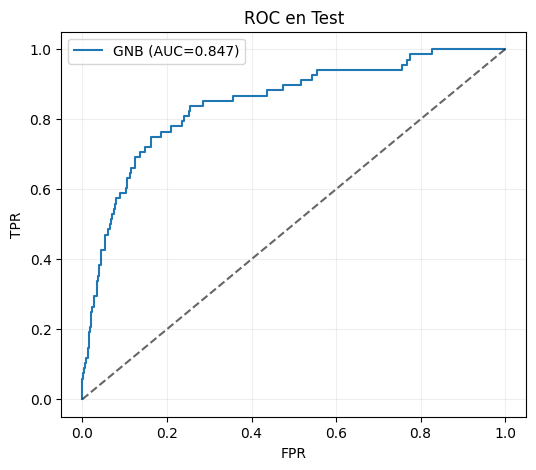

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pathlib import Path


gnb = GaussianNB().fit(X_train.values, y_train.values)
y_score_gnb = gnb.predict_proba(X_test.values)[:,1]


try:
    y_score_kde
except NameError:
    y_score_kde = None

fpr_gnb, tpr_gnb, _ = roc_curve(y_test.values, y_score_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)

plt.figure(figsize=(6,5))
plt.plot(fpr_gnb, tpr_gnb, label=f"GNB (AUC={roc_auc_gnb:.3f})")

if y_score_kde is not None:
    fpr_kde, tpr_kde, _ = roc_curve(y_test.values, y_score_kde)
    roc_auc_kde = auc(fpr_kde, tpr_kde)
    plt.plot(fpr_kde, tpr_kde, label=f"KDE-NB (AUC={roc_auc_kde:.3f})")

plt.plot([0,1],[0,1],'k--',alpha=.6)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC en Test")
plt.legend()
plt.grid(alpha=.2)
Path("figs").mkdir(exist_ok=True)
plt.savefig("figs/roc_test.png", dpi=140, bbox_inches="tight")
plt.show()


Distribuciones de verosimilitud (KDE)

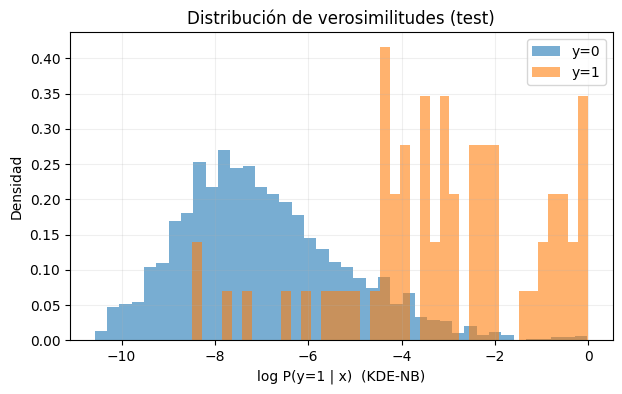

In [28]:
import numpy as np
import matplotlib.pyplot as plt

logp_test = np.log(kde_nb.predict_proba(X_test.values)[:,1] + 1e-12)

plt.figure(figsize=(7,4))
plt.hist(logp_test[y_test.values==0], bins=40, alpha=0.6, label="y=0", density=True)
plt.hist(logp_test[y_test.values==1], bins=40, alpha=0.6, label="y=1", density=True)
plt.xlabel("log P(y=1 | x)  (KDE-NB)")
plt.ylabel("Densidad")
plt.title("Distribución de verosimilitudes (test)")
plt.legend()
plt.grid(alpha=.2)
plt.savefig("figs/kde_logproba_hist.png", dpi=140, bbox_inches="tight")
plt.show()


Comparación de tiempos

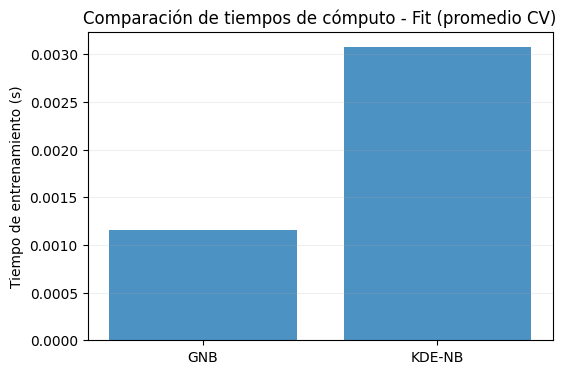

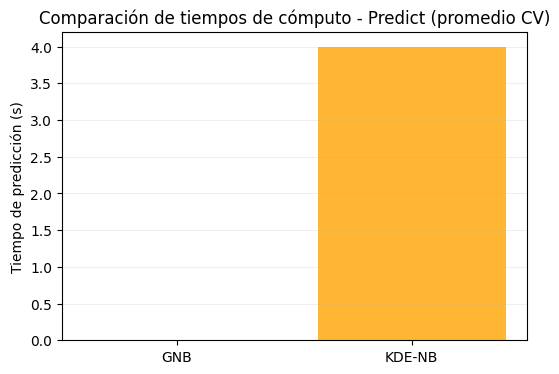

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

summary = pd.read_csv("cv_metrics_summary.csv")

plt.figure(figsize=(6,4))
plt.bar(summary["model"], summary["fit_mean_s"], alpha=.8)
plt.ylabel("Tiempo de entrenamiento (s)")
plt.title("Comparación de tiempos de cómputo - Fit (promedio CV)")
plt.grid(axis="y", alpha=.2)
plt.savefig("figs/fit_time_bar.png", dpi=140, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(summary["model"], summary["pred_mean_s"], alpha=.8, color="orange")
plt.ylabel("Tiempo de predicción (s)")
plt.title("Comparación de tiempos de cómputo - Predict (promedio CV)")
plt.grid(axis="y", alpha=.2)
plt.savefig("figs/predict_time_bar.png", dpi=140, bbox_inches="tight")
plt.show()
